# Import Dependencies

In [47]:
# Dependencies
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle

# Read Data File

In [2]:
# Data File
data = "../Resources/FINAL_CLEAN_FILE.csv"

# read to dataframe
data_df = pd.read_csv(data)
data_df.head()

,VAERS_ID,SYMPTOM,ASSIGNED_GROUP,SEVERITY_LEVEL,DIED,L_THREAT,HOSPITAL,AGE_YRS,AGE_GROUP,OTHER_MEDS,...,VAX_SITE_RA,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,916600,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,33.0,26-35,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,917168,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,64.0,56-65,1.0,...,1.0,0,0,0,0,1,0,0,0,0
2,918386,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,62.0,56-65,1.0,...,1.0,0,0,0,0,1,0,0,0,0
3,918393,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,62.0,56-65,1.0,...,1.0,0,0,0,0,1,0,0,0,0
4,918479,Dysphagia,Difficulty swallowing,MILD,0.0,0.0,0.0,37.0,36-45,1.0,...,1.0,0,0,1,0,0,0,0,0,0


In [3]:
severity = data_df['SEVERITY_LEVEL'].unique()
severity

array(['MILD', 'MODERATE', 'SEVERE'], dtype=object)

In [4]:
data_df.groupby(data_df['SEVERITY_LEVEL']).count()

,VAERS_ID,SYMPTOM,ASSIGNED_GROUP,DIED,L_THREAT,HOSPITAL,AGE_YRS,AGE_GROUP,OTHER_MEDS,CUR_ILL,...,VAX_SITE_RA,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
SEVERITY_LEVEL,,,,,,,,,,,,,,,,,,,,,
MILD,23836,23836,23836,23836,23836,23836,23836,23836,23836,23836,...,23836,23836,23836,23836,23836,23836,23836,23836,23836,23836
MODERATE,1984,1984,1984,1984,1984,1984,1984,1984,1984,1984,...,1984,1984,1984,1984,1984,1984,1984,1984,1984,1984
SEVERE,662,662,662,662,662,662,662,662,662,662,...,662,662,662,662,662,662,662,662,662,662


# Prep Data for Model

In [5]:
# Create Features by dropping columns we do not need (or already have in feature format)
X = data_df.drop(['VAERS_ID', 'SYMPTOM','ASSIGNED_GROUP','SEVERITY_LEVEL','HOSPITAL', 'DIED', 'L_THREAT', 'CUR_ILL', 'VAX_SITE_LA', 'VAX_SITE_RA', 'AGE_YRS', 'AGE_GROUP'], axis=1)
X

,OTHER_MEDS,HISTORY,PRIOR_VAX,ALLERGIES,F,M,JANSSEN,MODERNA,PFIZER,VAX_DOSE_SERIES_1,VAX_DOSE_SERIES_2,18-25,26-35,36-45,46-55,56-65,66-75,76-85,86-95,96 +
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0
1,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0
2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0
3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,1,0,0,0,0
4,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26477,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0,0,0,1,0,0,0
26478,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0
26479,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0
26480,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0


In [6]:
# Create Target (Severity Level column) and convert to numbers
y = LabelEncoder().fit_transform(data_df['SEVERITY_LEVEL'])
y

array([0, 0, 0, ..., 2, 1, 1])

In [7]:
# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Test KNN Model

In [8]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []

for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")

k: 1, Train/Test Score: 0.847/0.844
k: 3, Train/Test Score: 0.894/0.893
k: 5, Train/Test Score: 0.895/0.894
k: 7, Train/Test Score: 0.897/0.895
k: 9, Train/Test Score: 0.899/0.900
k: 11, Train/Test Score: 0.897/0.897
k: 13, Train/Test Score: 0.899/0.900
k: 15, Train/Test Score: 0.899/0.902
k: 17, Train/Test Score: 0.899/0.902
k: 19, Train/Test Score: 0.899/0.901


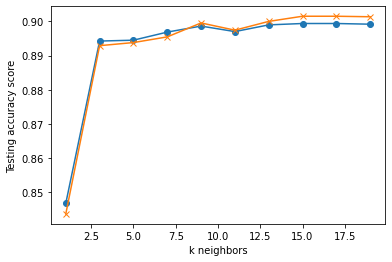

In [9]:
# Plot K Results
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

# Create KNN Model

In [13]:
# Note that k: 13 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)
print('k=13 Test Acc: %.3f' % knn.score(X_test, y_test))

k=13 Test Acc: 0.900


# Test Predict

In [42]:
# Sample Prediction 1
sample_user1 = [[1,1,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1]]
predicted_symptoms1 = knn.predict(sample_user1)
print(severity[predicted_symptoms1])

['MILD']


# Get Nearest Neighbors Symptoms

In [38]:
# Return 50 closest symptoms for those nearest neighbors
tree = KDTree(X)
dist, ind = tree.query(sample_user1, k=50)

#convery ndarry to list 
like_users = ind[0].tolist()
print(like_users)  # indices of closest neighbors

[24399, 4421, 9823, 13471, 21509, 5634, 20640, 8215, 25028, 15392, 5074, 7598, 5771, 19147, 26333, 20781, 8773, 10413, 20582, 4169, 12313, 12227, 12068, 4545, 4273, 5128, 581, 12409, 4367, 4380, 5042, 12436, 12137, 12511, 4974, 11683, 4597, 10403, 5022, 4518, 12496, 12274, 4165, 10422, 11094, 4512, 12094, 10915, 10257, 12161]


In [39]:
# save nearest neighbors symptoms as list for wordcloud
get_symptoms = data_df['ASSIGNED_GROUP'].iloc[like_users].tolist()
symptom_array = np.array(get_symptoms)
nearest_symptoms = np.unique(symptom_array)
nearest_symptoms


array(['Abdominal Pain/Discomfort', 'Anaphylactic reaction', 'Arterial',
       'Chest Discomfort', 'Chills', 'Cough', 'Fatigue', 'Fever',
       'Injection Site Irritation/Discomfort', 'Joint Pain/Discomfort',
       'Lethargy', 'Migraine/Headache', 'Neck pain', 'Pulmonary',
       'Taste abnormal', 'Weakness'], dtype='<U36')

# Plot Wordcloud

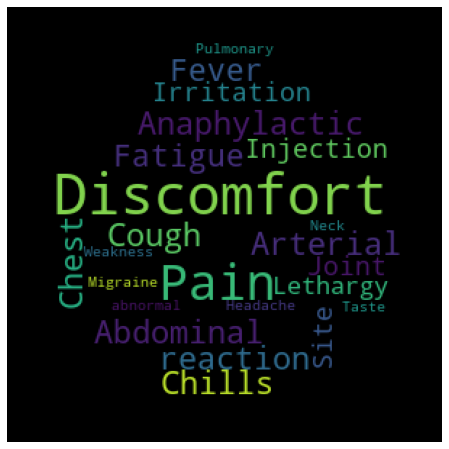

In [40]:
#convert list to string and generate
unique_string=(" ").join(nearest_symptoms)

#create circle mask
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(width = 1000, height = 500, mask=mask).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()


# Another Sample Prediction

In [41]:
# Sample Prediction 2
sample_user2 = [[1,1,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1]]
predicted_symptoms2 = knn.predict(sample_user2)
print(severity[predicted_symptoms2])

['MILD']


In [43]:
# Return 50 closest symptoms for those nearest neighbors
tree = KDTree(X)
dist, ind = tree.query(sample_user2, k=50)

#convery ndarry to list 
like_users2 = ind[0].tolist()
print(like_users2)  # indices of closest neighbors

[24399, 4421, 9823, 13471, 21509, 5634, 20640, 8215, 25028, 15392, 5074, 7598, 5771, 19147, 26333, 20781, 8773, 10413, 20582, 4169, 12313, 12227, 12068, 4545, 4273, 5128, 581, 12409, 4367, 4380, 5042, 12436, 12137, 12511, 4974, 11683, 4597, 10403, 5022, 4518, 12496, 12274, 4165, 10422, 11094, 4512, 12094, 10915, 10257, 12161]


In [44]:
# save nearest neighbors symptoms as list for wordcloud
get_symptoms2 = data_df['ASSIGNED_GROUP'].iloc[like_users2].tolist()
symptom_array2 = np.array(get_symptoms2)
nearest_symptoms2 = np.unique(symptom_array2)
nearest_symptoms2


array(['Abdominal Pain/Discomfort', 'Anaphylactic reaction', 'Arterial',
       'Chest Discomfort', 'Chills', 'Cough', 'Fatigue', 'Fever',
       'Injection Site Irritation/Discomfort', 'Joint Pain/Discomfort',
       'Lethargy', 'Migraine/Headache', 'Neck pain', 'Pulmonary',
       'Taste abnormal', 'Weakness'], dtype='<U36')

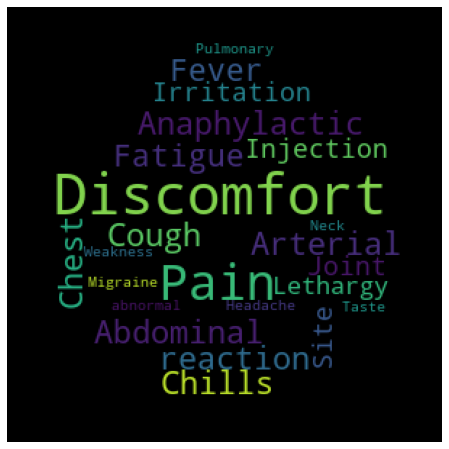

In [45]:
#convert list to string and generate
unique_string2=(" ").join(nearest_symptoms2)

#create circle mask
x2, y2 = np.ogrid[:300, :300]
mask2 = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask2 = 255 * mask2.astype(int)

wordcloud2 = WordCloud(width = 1000, height = 500, mask=mask).generate(unique_string2)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()


# Save the Model

In [48]:
# save model
with open(f'../final_knn_model.sav', 'wb') as f:
    pickle.dump(knn, f)
    

# User Input

In [49]:
# Define list of features and create empty user input list
features_np = ['OTHER_MEDS', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES', 'F', 'M', 'JANSSEN', 'MODERNA', 'PFIZER',
       'VAX_DOSE_SERIES_1', 'VAX_DOSE_SERIES_2', '18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '86-95',
       '96 +']
user_input = np.zeros(len(features_np))


In [50]:
# Raw User Input from user fields
age_group = '36-45'
sex = 'F'
other_meds = 0
history = 0
prior_vax = 0
allergies = 0
vax_name = 'PFIZER'
vax_dose = '2'

# Convert user input to list for model

age_idx = features_np.index(f'{age_group}')
sex_idx = features_np.index(f'{sex}')
vax_idx = features_np.index(f'{vax_name}')
dose_idx = features_np.index(f'VAX_DOSE_SERIES_{vax_dose}')

user_input[0] = other_meds
user_input[1] = history
user_input[2] = prior_vax
user_input[3] = allergies
user_input[sex_idx] = 1
user_input[vax_idx] = 1
user_input[dose_idx] = 1
user_input[age_idx] = 1


print(user_input)


[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [51]:
# Real Prediction
user_test = user_input
predicted_symptoms = knn.predict([user_test])
print(severity[predicted_symptoms])

['MILD']
